In [ ]:
!wget https://github.com/luisgasco/ntic_master_datos/raw/main/datasets/datos_twitter_master.tsv
!pip install emoji_extractor
!pip install emoji
import sys  
!{sys.executable} -m pip install contractions
!python -m spacy download en_core_web_sm
import nltk
nltk.download('stopwords')
# Download emoji sentiment
!wget https://www.clarin.si/repository/xmlui/handle/11356/1048/allzip
!unzip allzip

--2021-06-05 11:28:51--  https://github.com/luisgasco/ntic_master_datos/raw/main/datasets/datos_twitter_master.tsv
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/datos_twitter_master.tsv [following]
--2021-06-05 11:28:52--  https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/datos_twitter_master.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113587 (111K) [text/plain]
Saving to: ‘datos_twitter_master.tsv’

datos_twitter_maste 100%[===================>] 110.92K  --.-KB/s    in 0.05s   

2021-06-05 11:28:52 (2.21 MB/s) - ‘dato

# Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import contractions
import re
from emoji_extractor.extract import Extractor
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report


# Funciones que se utilizarán

In [ ]:
# Preparar diccionario de emojis
def load_emoji_sentiment(path):
  # Cargamos el csv de emoji_sentiment
  emoji_sent_df = pd.read_csv(path,sep=",")
  # Calculamos los scores dividiendo el número de emojis negativos y entre el total
  emoji_sent_df["Negative"] = emoji_sent_df["Negative"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Neutral"] = emoji_sent_df["Neutral"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Positive"] = emoji_sent_df["Positive"]/emoji_sent_df["Occurrences"]
  # Transformamos a dict
  emoji_sent_df = emoji_sent_df.set_index('Emoji')
  emoji_dict = emoji_sent_df.to_dict(orient="index")
  return emoji_dict

In [ ]:
# Reemplazar contracciones y slang en inglés usando la librería "contractions" https://github.com/kootenpv/contractions
def replace_contraction(text):
    expanded_words = []
    # Divide el texto
    for t in text.split():
        # Aplica la función fix en cada sección o token del texto buscando contracciones y slang
        expanded_words.append(contractions.fix(t, slang = True))
    expanded_text = ' '.join(expanded_words) 
    return expanded_text

# Hay un tokenizador guay para twitter https://github.com/jaredks/tweetokenize



In [ ]:
# Función para extraer emojis del texto en formato lista
def extract_emojis(text):
  extract = Extractor()
  emojis = extract.count_emoji(text, check_first=False)
  emojis_list = [key for key, _ in emojis.most_common()]
  return emojis_list

In [ ]:
# Calcula el sentimiento de los emojis de una lista utilizando el diccionario
# de emoji sentiment score generado previamente con la función load_emoji_sentiment()
# Se puede extraer el valor de positividad de los emojis con la option "positive"
# Se puede extraer el valor de neutralidad de los emojis con la option "neutral""  
# Se puede extraer el valor de e negatividad de los emojis con la option "negative""  

def get_emoji_sentiment(lista, option = "positive"):
  output = 0
  for emoji in lista:
    try:
      if option == "positive":
        output = output + emoji_sent_dict[emoji]["Positive"]
      elif option =="negative":
        output = output + emoji_sent_dict[emoji]["Negative"]
      elif option =="neutral":
        output = output + emoji_sent_dict[emoji]["Neutral"]
    except Exception as e: 
      continue
  return output

In [ ]:
# Eliminar los emojis de un texto. Esto es útil porque una vez extraido los emojis
# puede interesarnos tener un texto sin presencia de emojis para mejor análisis.
def clean_emoji(text):
    # Poner todos los comandos de http://www.unicode.org/Public/emoji/1.0/emoji-data.txt
    emoji_pattern = re.compile("["
        u"\U0001F300-\U0001F6FF"  # symbols & pictographs
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u'\u2600-\u26FF\u2700-\u27BF'
        u'\u2934' u'\u2935' u'\u2B05' u'\u2B06' u'\u2B07' u'\u2B1B' u'\u2B1C' 
        u'\u2B50' u'\u2B55' u'\u3030' u'\u303D' u'\u3297' u'\u3299' u'\u00A9'
        u'\u00AE' u'\u203C' u'\u2049' u'\u2122' u'\u2139' u'\u2194-\u2199' 
        u'\u21A9' u'\u21AA' u'\u231A' u'\u231B' u'\u2328' u'\u23CF'
        u'\u23E9-\u23F3' u'\u23F8' u'\u23F9' u'\u23FA' u'\u24C2' u'\u25AA'
        u'\u25AB' u'\u25B6' u'\u25C0' u'\u25FB' u'\u25FD' u'\u25FC' u'\u25FE'
        ']+', flags=re.UNICODE)
    string2 = re.sub(emoji_pattern,r' ',text)
    return string2

In [ ]:
# Tokenizar los tweets con el tokenizador "TweetTokenizer" de NLTK
def tokenize(texto):
  tweet_tokenizer = TweetTokenizer()
  tokens_list = tweet_tokenizer.tokenize(texto)
  return tokens_list

# Quitar stop words de una lista de tokens
def quitar_stopwords(tokens):
    stop_words = set(stopwords.words('english')) 
    filtered_sentence = [w for w in tokens if not w in stop_words]
    return filtered_sentence


# Eliminar signos de puntuación de una lista de tokens
# (nos quedamos sólo lo alfanumérico en este caso)
def quitar_puntuacion(tokens):
    words=[word for word in tokens if word.isalnum()]
    return words


# Lemmatization de los tokens. Devuelve una string entera para hacer la tokenización
# con NLTK
nlp = en_core_web_sm.load(disable=['parser', 'ner'])
def lematizar(tokens):
    sentence = " ".join(tokens)
    mytokens = nlp(sentence)
    # Lematizamos los tokens y los convertimos  a minusculas
    mytokens = [ word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Extraemos el text en una string
    return " ".join(mytokens)


# Cargar y preparar los datos
En primer lugar cargamos los datos que vamos a utilizar en este notebook (emoji_sentiment_data y datos de twitter).

In [ ]:
emoji_sent_dict = ________________________________________

Podemos textear que hemos obtenido un diccionario cuyas claves son los emojis presentes dentro de emoji sentiment score. Cada emoji tiene un score de negatividad, neutralidad, positividad y otros campos.

In [ ]:
emoji_sent_dict["😭"]

{'Negative': 0.4364820846905538,
 'Neutral': 0.22041259500542887,
 'Occurrences': 5526,
 'Position': 0.803351976,
 'Positive': 0.34310532030401736,
 'Unicode block': 'Emoticons',
 'Unicode codepoint': '0x1f62d',
 'Unicode name': 'LOUDLY CRYING FACE'}

Cargamos el fichero datos_twitter_master.tsv con los datos de Twitter:

In [ ]:
dataset = _____________________________
dataset.head(3)

,tweet_text,molestia
0,Noise harassment is a sensation pain based tor...,1
1,It's 4.30am and we still haven't slept because...,1
2,These birds acting like I can't grab my chains...,1


# Análisis preliminar 

In [ ]:
print("Tenemos un conjunto de {} tweets".format(____________________________)))
print("El dataframe tiene {} columnas".format(______________________________))

Tenemos un conjunto de 1020 tweets
El dataframe tiene 2 columnas


In [ ]:
print("Existen {} tweets duplicados".format(np.sum(dataset.duplicated(subset=["tweet_text"]))))
# Quitaremos esos duplicados
dataset = dataset.drop_duplicates()
print("Despues de quitar duplicados tenemos un conjunto de {} tweets".format(dataset.shape[0]))

Existen 1 tweets duplicados
Despues de quitar duplicados tenemos un conjunto de 1019 tweets


In [ ]:
print("Hay {} valores vacíos en las tweets y {} valores vacíos en las etiquetas en los datos".format(np.sum(dataset.isnull())[0],
                                                                                                        np.sum(dataset.isnull())[1]))

Hay 0 valores vacíos en las tweets y 0 valores vacíos en las etiquetas en los datos


Vemos que en la columna "molestia" nos encontramos las etiquetas del dataset. En este caso nos encontramos dos tipos de documentos (tweets):

- "Molestia = 1": Tweets con la palabra ruido que hacen referencia a molestias sufridas por ruido acústico proveniente de distintas fuentes (coches, vecinos, mascotas,...)
- "Molestia = 0": Tweets que contienen la palabra ruido perso no expresan una molestia sufrida por el usuario que lo escribió (otras acpciones de ruido, noticias que hablan sobre ruido o uso de ruido como algo positivo) 

Comprobemos la distribución de las clases:

In [ ]:
dataset["molestia"].______________________________

1    510
0    509
Name: molestia, dtype: int64

Vamos a pintar la distribución de la longitud de los tweets para cada una de las clases

In [ ]:
# Calculamos la variable longitud
dataset["char_len"] = __________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


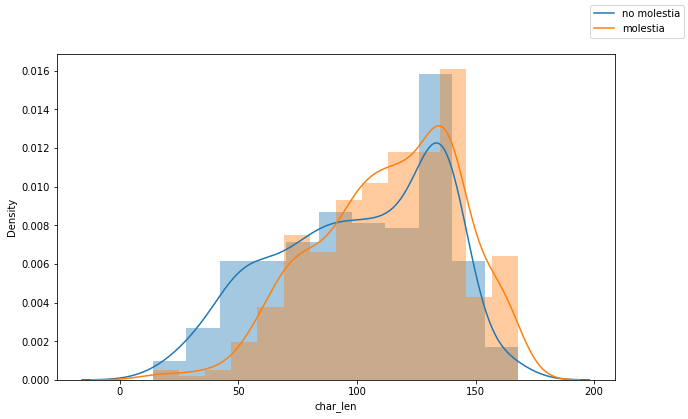

In [ ]:
fig = plt.figure(figsize=(10,6))
plt1 = sns.distplot(________________________________, hist=True, label="molestia")
plt2 = sns.distplot(________________________________, hist=True, label="no molestia")
fig.legend(labels=['no molestia','molestia'])
plt.show()

En la figura se ve que no existen diferencias significativas entre las dos clases. Quizá los tweets en los que el usuario se queja sobre el ruido (molestia ==1)tienen una tendencia a ser más cortos, pero no se observa nada destacable.

# Transformación 

Como hemos visto, está dividido en dos pasos Normalización o Preprocesado y Transformación



## Normalización
Vamos a proceder a normalizar los datos. Para ello vamos a utilizar las funciones anteriormente definidas:

- Por una parte vamos a extraer los emojis de los tweets, los vamos a guardar en una lista dentro de una nueva columna del dataframe y por último calcularemos un valor de sentimiento de emojis de positividad, negatividad y neutralidad.

- Preprocesar los textos:
    - Primero expanderemos las contracciones de los tweets
    - Despues quitaremos los emojis, ya que antes habremos calculado los scores necesarios.
    - Tokenizaremos
    - Quitaremos stop words
    - Quitaremos puntuación
    - Lematizaremos

### Emojis
En primer luigar vamos a trabajar con los emojis. 

Vamos a extraerlos con una función lambda aplicando la función extract_emojis() definida anteriormente en el dataframe

In [ ]:
dataset["emoji_list"] = dataset["tweet_text"].apply(lambda x: _____________________)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Vemos que nos ha guardado los emojis en la columna "emoji_list":

In [ ]:
dataset["emoji_list"]

0        []
1        []
2        []
3        []
4       [🎻]
       ... 
1015     []
1016     []
1017     []
1018     []
1019     []
Name: emoji_list, Length: 1019, dtype: object

A continuación, se calcula un score de sentimiento a los emojis asociados a cada tweet. Si no hay emojis, estos scores serán cero.
Para calcular esto lo haremos de nuevo con funciones lambda aplicando la función get_emoji_sentiment() anteriormente generada:

In [ ]:
dataset["sent_emoji_pos"] = dataset["emoji_list"].apply(lambda x: get_emoji_sentiment(x,"positive")) #positive
dataset["sent_emoji_neu"] = dataset["emoji_list"].apply(lambda x: get_emoji_sentiment(x,"neutral")) #neutral
dataset["sent_emoji_neg"] = dataset["emoji_list"].apply(lambda x: get_emoji_sentiment(x,"negative")) #negative

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

### Preprocesar textos
Vamos a realizar los preprocesados indicados antes.

 En primer lugar expandimos las contracciones. Además, despues del proceso de extracción de emojis, los quitaremos de nuestros textos porque no nos serán útiles.

In [ ]:
# Reemplazar contracciones
dataset["tweet_text_processed"] = dataset["tweet_text"].apply(lambda x: __________________________)
# Quitar emojis de los textos
dataset["tweet_text_processed"] = dataset["tweet_text_processed"].apply(lambda x: ________________________)  #CleanEmoji de tweet_text_processed

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Despues tokenizamos el texto, y trabajaremos en limpiar los tokens que no son útiles en este problema para reducir dimensionalidad

In [ ]:
dataset["tokenized"] = dataset["tweet_text_processed"].apply(lambda x: ___________________________)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Procesamos los tokens:

In [ ]:
# Quitar stopwords
dataset["tokenized_clean"] = dataset["tokenized"].apply(lambda x: _______________________) #quitar_stopwords
# Quitamos los símbolos de puntuación
dataset["tokenized_clean"] = dataset["tokenized_clean"].apply(lambda x: ___________________________) #quitar_puntuacion
# Lematizamos
dataset["lematizacion"] = dataset["tokenized_clean"].apply(lambda x:___________________________) #lematizar

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

En este paso también podríamos generar nuevas características para mejorar el funcionamiento del algoritmo. Por ejemplo, podríamos utilizar TextBlob para obtener el sentimiento (tanto subjetividad y polaridad) de cada twitter. Esto se hace de la siguiente forma:


```
from textblob import TextBlob
Textblob(tweet_text).sentiment.subjectivity
Textblob(tweet_text).sentiment.polarity
```

PAra aplicarlo a cada texto de un dataframe habría que utilizar funciones Lambda.

## Vectorización

Una vez hemos limpiado y procesado el texto, vamos a extraer características utilizando TFIDFVectorizer:
- Queremos utilizar como máximo *30* features
- unigramas, bigramas y trigramas
- Que el sistema no considere los elementos que salgan en menos del 5% de los documentos.

In [ ]:
# BoW Features
vectorizador = TfidfVectorizer(________________________________ )
vector_data = vectorizador.fit_transform(dataset["lematizacion"])

In [ ]:
vector_data

<1019x30 sparse matrix of type '<class 'numpy.float64'>'
	with 2710 stored elements in Compressed Sparse Row format>

# Entrenar/testear el clasificador

En esta ocasión, además de utilizar las características de *Bag of Ngramas* generadas con TfidfVectorizer, nos interesa utilizar otro conjunto de características que podrían ser de interés para mejorar el rendimiento del clasificador.

En este caso, vamos a introducir como ejemplo las variables de sentimiento de emojis que hemos calculado.

La forma más sencilla de hacer esto es utilizar la librería *scipy* y generar una matriz sparse, comprensible por scikit-learn, que contenga tanto las características de TFIDF como las calculadas manualmente. 

En primer lugar, debemos seleccionar el conjunto de variables que queremos considerar en el entrenamiento. PAra ello hacemos uso del selector `dataframe[["nombre_columna1", "nombre_columna2"]]`:

In [ ]:
extra_features = _________________________________________

Utilizamos la librería spacy (función sparse.hstack) para unir las características TFIDF (contenidas en ´vector_data´) con las que acabamos de seleccionar (´extra_features´). Esta unión nos generará una matriz X que utilizaremos para hacer el train-test split posteriormente:

In [ ]:
import scipy as sp
# Extraemos las etiquetas y las asignamos a la variable y
y = dataset["molestia"].values.astype(np.float32) 
# Unimos las características TFIDF con las características previamente seleccionadas
# Extraemos los valores (values) de las extra_features, que es un dataframe  
# Hay que guardar vector_data (que es una sparse matrix) con extra_features.
# Elegimos el formato "csr", Compressed Sparse Row matrix, que es el formato de
# resultado de tfidfVectorizer 
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform
X = sp.sparse.hstack((vector_data,extra_features.values),format='csr')

También vamos a extraer el nombre de las caracteríticas por si quisieramos utilizarlos con posterioridad.

In [ ]:
X_columns=vectorizador.get_feature_names()+extra_features.columns.tolist()

Vamos a dividir nuestros datos en Train y Test, como habitualmente se hace. En este caso probablemente tuvieramos demasiadas características (303 características para 764 datos nos va a dar problemas de overfitting, así que en los ejercicios deberías tener esto en cuenta [bajas el número de características])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Definimos las variables para hacer una grid_searc:

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]


In [ ]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = KFold(n_splits=4, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Vamos a entrenar el grid_search para obtener el mejor parámetro para nuestro conjunto de datos.

In [ ]:
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))


Mejor accuracy: 0.725131 usando los parámetros {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


Entrenamos el modelo con los resultados ofrecidos por la grid_search:

In [ ]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=LogisticRegression(C=100, penalty="l2", solver = "newton-cg")
model.fit(X_train,y_train)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

Vamos a ver como funciona el modelo haciendo el predict del test y mostrando la matriz de confusióñn y el classifciation_Report:

In [ ]:
y_pred = model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[112  21]
 [ 37  85]]
              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79       133
         1.0       0.80      0.70      0.75       122

    accuracy                           0.77       255
   macro avg       0.78      0.77      0.77       255
weighted avg       0.78      0.77      0.77       255



Además, podríamos mostrar el grado de importancia relativa de las variables dle modelo. Aquí hago el listado, pero lo ideal sería seleccionar las más importantes dentro del modelo para saber cuales están teniendo más influencia:

In [ ]:
# Obtener la importancia de las variables del modelo
importance = model.coef_[0]


A continuación utilizamos esa variable de importancia de variables, junto a los nombres de las características almacenadas anteriormente en X_columns, para listar la importancia de cada una de las variables.

Feature: 0, Name: be , Score: 0.53018
Feature: 1, Name: complaint , Score: -1.49197
Feature: 2, Name: fucking , Score: 7.84474
Feature: 3, Name: get , Score: 2.15184
Feature: 4, Name: go , Score: 1.94110
Feature: 5, Name: hear , Score: 1.34631
Feature: 6, Name: house , Score: 2.90794
Feature: 7, Name: like , Score: 2.03230
Feature: 8, Name: live , Score: 1.04298
Feature: 9, Name: loud , Score: 3.02569
Feature: 10, Name: make , Score: 2.42336
Feature: 11, Name: make much , Score: 5.00942
Feature: 12, Name: make much noise , Score: -1.66389
Feature: 13, Name: make noise , Score: 2.44617
Feature: 14, Name: much , Score: 2.15544
Feature: 15, Name: much noise , Score: 2.71280
Feature: 16, Name: my , Score: 2.92102
Feature: 17, Name: neighbor , Score: 1.79258
Feature: 18, Name: new , Score: -0.61146
Feature: 19, Name: night , Score: 1.77640
Feature: 20, Name: noise , Score: 1.63937
Feature: 21, Name: noise complaint , Score: 1.33042
Feature: 22, Name: noise pollution , Score: -0.64312
Featur

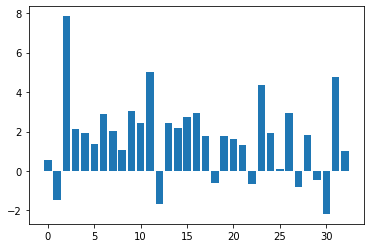

In [ ]:
# Mostrar el número de la característica, con su nombre, y su score de importancia
for i,v in enumerate(importance):
 print('Feature: %0d, Name: %s , Score: %.5f' % (i,X_columns[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()